In [ ]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
import numpy as np                                    # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                       # Pyplot para plotagem de gráficos e imagens.
from sklearn.metrics import confusion_matrix          # Scikit-Learn para plotar a matriz de confusão
import seaborn as sn
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras
from tensorflow.keras.models import load_model        # Função para carregar um modelo salvo
from tensorflow.keras.models import Sequential        # Classe de modelos sequenciais para construir as redes neurais.
from tensorflow.keras.applications import VGG16       # Rede pre treinada (VGG16)

from google_drive_downloader import GoogleDriveDownloader as gdd

# ImageDataGenerator, utilizado para carregar imagens em tempo de execução
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/DR_test_aumentada.zip"

In [ ]:
!unzip "/content/DR_train_aumentada.zip"

In [ ]:
!unzip "/content/DR_validation_aumentada.zip"

In [ ]:
hyperparameters  = {'input_height':250, 'input_width':250, 'input_channels':3, 'batchsize': 64}

In [ ]:
partition = '/content/drive/MyDrive/skin cancer ham 10000 - dados/Trainmodified'

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, partition, hyperparameters, aug_dict = None, 
                 sampling = None, shuffle = True, seed = None):

        # Generates random seed if not provided
        if seed is None:
            seed = np.random.randint( 0, 255)

        # Sets the given seed to random, numpy and tensorflow for reproducibility
        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

        # How the sampling should be done, can be either:
        # None, for regular sampling from ImageDataGenerator
        # oversampling, for random oversampling
        # undersampling, for random undersampling
        self.sampling = None
        if isinstance(sampling, str) and sampling.lower() in ["oversampling", "undersampling"]:
            self.sampling = sampling.lower()

        # Extracts the targeted shape
        inputH = hyperparameters["input_height"]
        inputW = hyperparameters["input_width"]
        inputC = hyperparameters["input_channels"]
        
        # Defines other metadata based on the given parameters 
        self.batch_size = hyperparameters["batchsize"]
        self.input_size = (inputH, inputW, inputC)
        self.shuffle = shuffle

        # Gets the dataframe with input/output paths 

        #self.base_df = dataset.get_dataframe(partition)
        
        # Gets the relative path to the dataset
        image_dir = f"{inputH}x{inputW}"
        #data_path = os.path.join( self.meta_dir, f"{}_data.csv" )
        self.import_dir = partition
        
        # If the targeted size is unavailable,
        # samples are resized from 512x512 images
        if not os.path.exists(self.import_dir):
           print('Please, insert a path of your data_set')
            #self.import_dir = os.path.join(data_path, "original")    

        # Gets the names of the input and output columns in the dataf ame
        # self.X_col = dataset.input_col
        # self.Y_col = dataset.output_col

        # Identifies each individual class from given labels
        images = ImageDataGenerator()
        images_dir = images.flow_from_directory(partition, target_size = (250, 250),
                                                 batch_size  = 64)
        #evaluate samples
        val_samples = images_dir.samples 
        #evaluate class to index
        self.label2class_dict = images_dir.class_indices
        #evaluate index to class
        self.class2label_dict = { v: k for k, v in class_to_idx_dict.items() }

        #below, this code is doing the samething then code above

        #self.unq_labels = [ clss for clss in dataset.classes.keys() ]
        #self.label2class_dict = { label: clss for clss, label in enumerate(self.unq_labels) }
        #self.class2label_dict = { clss: label for clss, label in enumerate(self.unq_labels) }

        # Gets the number of samples and the number of classes in the dataset
        self.n = images_dir.samples
        self.n_classes = len(val_generator.class_indices)

     #   if self.n_classes != len(self.unq_labels):
      #      print( f"\nOnly {dataset.n_classes} of {self.n_classes} classes are represented in this dataset..." )
            
        # Saves the augmentation dict whithin the generator class
        self.set_datagen_transformations( hyperparameters, aug_dict )
        self.set_generator()

        return
    
    @staticmethod
    def custom_preprocess_input(model_input):
        model_input = model_input.astype(np.float32)
        
        # Maps images from [0 ~ 255] to [-1, 1]
        model_input /= 127.5
        model_input -= 1
        
        return model_input

    def get_sampled_df(self, sub_df, ref_samples):
        if ref_samples == len(sub_df):
            return sub_df
        
        if self.sampling == "undersampling":
            # Undersamples larger dfs to match ref_samples
            sub_df = sub_df.sample(n = ref_samples, replace = False)
        
        if self.sampling == "oversampling":
            # Upsamples smaller dfs to match ref_samples
            sub_df = sub_df.sample(n = ref_samples, replace = True)
            
        sub_df.reset_index(drop = True, inplace = True)
        return sub_df

    def resample_dataframe( self, src_df ):
        if self.sampling is None:
            return src_df
        
        class_dfs = []
        class_samples = []
        for label in self.label2class_dict.keys():
            class_dfs.append(src_df[src_df[self.Y_col] == label].copy(deep = True))
            class_samples.append( len(class_dfs[-1]) )
        
        max_samples = np.max(class_samples)
        min_samples = np.min(class_samples)
        ref_samples = max_samples if self.sampling == "oversampling" else min_samples
        
        # Resamples each class' dataframe based on the sampling method
        class_dfs = [self.get_sampled_df(df, ref_samples) for df in class_dfs]
        dst_df = pd.concat(class_dfs, axis = 0, ignore_index = True)
        
        if self.shuffle:
            dst_df = dst_df.sample(frac=1).reset_index(drop=True)
        
        return dst_df
    
    def set_datagen_transformations(self, hyperparameters, augmentation_dict):
        
        if (augmentation_dict is None) or (not hyperparameters["augmentation"]):
            # Transformations for ImageDataGenerator
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.,
                              preprocessing_function = CustomDataGenerator.custom_preprocess_input )
        
        else:
            # Zoom range for data augmentation
            zoom_range = ( 1. - augmentation_dict["zoom_in"], 
                           1. + augmentation_dict["zoom_out"] )

            # brightness range for data augmentation
            brightness_range = ( 1. - augmentation_dict["brightness"], 
                                 1. + augmentation_dict["brightness"] )

            # Transformations for ImageDataGenerator
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale           = 1.,
                                                                      rotation_range         = augmentation_dict["rotation"],
                                                                      shear_range            = augmentation_dict["shear"],
                                                                      brightness_range       = brightness_range,
                                                                      width_shift_range      = augmentation_dict["horizontal_translation"],
                                                                      height_shift_range     = augmentation_dict["vertical_translation"],
                                                                      zoom_range             = zoom_range,
                                                                      horizontal_flip        = augmentation_dict["horizontal_flip"],
                                                                      vertical_flip          = augmentation_dict["vertical_flip"],
                                                                      fill_mode              = augmentation_dict["fill_mode"],
                                                                      cval                   = augmentation_dict["constant_val"], 
                                                                      preprocessing_function = CustomDataGenerator.custom_preprocess_input
                                                                     )
        return

    def set_generator(self):

        self.df = self.resample_dataframe(self.base_df)
    
        input_H, input_W, input_C = self.input_size
        color_mode = "grayscale" if input_C == 1 else "rgb"

        # Adjusts labels in the generator's dataframe to keep desired class order (0: not COVID, 1: COVID)
        gen_df = self.df.copy(deep = True)
        gen_df[self.Y_col] = gen_df.apply( lambda r: int(self.label2class_dict[r[self.Y_col]]), axis = 1 )

        # Builds a data generator object
        self.generator = self.datagen.flow_from_dataframe(dataframe = gen_df, x_col = self.X_col, y_col = self.Y_col, 
                                target_size = (input_H, input_W), batch_size = self.batch_size, class_mode = "raw",
                                directory = self.import_dir, color_mode = color_mode, shuffle = False, 
                                seed = self.seed)
        return 
    
    def on_epoch_end(self):
        # On the end of each epoch, if applying random undersampling or 
        # oversampling, resets the generator to choose new samples 
        # for the next epoch
        if not self.sampling is None:
            self.set_generator()
        return 

    def get_labels(self):
        # Gets all labels in the dataframe as their corresponding class numbers
        return [self.label2class_dict[l] for l in self.df[self.Y_col].to_list()]
        
    def get_fnames(self):
        # Gets all labels in the dataframe as their corresponding class numbers
        return [os.path.basename(p) for p in self.df[self.X_col].to_list()]
    
    def __getitem__(self, index):
        return self.generator.__getitem__(index)
    
    def __len__(self):
        # Returns the number of batches the generator can produce
        return len(self.generator)


In [ ]:
val_datagen   = ImageDataGenerator( rescale = 1./255 )
val_generator = val_datagen.flow_from_directory("/content/drive/MyDrive/skin cancer ham 10000 - dados/DR_validation3/ValidResized", target_size = (250, 250),
                                                 batch_size  = 64)

Found 501 images belonging to 7 classes.


In [ ]:
# Atributo do generator que fornece o número de amostras detectadas
val_samples = val_generator.samples 
print(val_samples, "amostras detectadas")

# Atributo do generator que fornece o mapeamento de classe para índice 
# Repare que os índices são definidos pelo generator com base nos diretórios de arquivos em ordem alfabética
class_to_idx_dict = val_generator.class_indices
print( "Mapeamento Classes -> Índices:", class_to_idx_dict )

# Construção de um novo dicionário que inverte o mapeamento
idx_to_class_dict = { v: k for k, v in class_to_idx_dict.items() }
print( "Mapeamento Índices -> Classes:", idx_to_class_dict )

501 amostras detectadas
Mapeamento Classes -> Índices: {'AKIECValidation3resized': 0, 'BCCValidation3resized': 1, 'BKLValidation3resized': 2, 'DFValidation3resized': 3, 'MELValidation3resized': 4, 'NVValidation3resized': 5, 'VASCValidation3resized': 6}
Mapeamento Índices -> Classes: {0: 'AKIECValidation3resized', 1: 'BCCValidation3resized', 2: 'BKLValidation3resized', 3: 'DFValidation3resized', 4: 'MELValidation3resized', 5: 'NVValidation3resized', 6: 'VASCValidation3resized'}


In [ ]:
class_to_idx_dict.keys()

dict_keys(['AKIECaugumentaded', 'BCCaugumentaded', 'BKLaugumentaded', 'DFaugumentaded', 'MELaugumentaded', 'NVaugumentaded', 'VASCaugumentaded'])

In [ ]:
from collections import Counter
counter = Counter(val_generator.classes)
counter

Counter({0: 76, 1: 64, 2: 68, 3: 100, 4: 50, 5: 157, 6: 15})

In [ ]:
train_datagen = ImageDataGenerator(
                  rescale = 1. / 255,        # normalizando as imagens
                  rotation_range = 20,       # Rotação aleatória de até 20°
                  width_shift_range = 0.2,   # Translação horizontal de até 20% da largura
                  height_shift_range = 0.2,  # Translação vertical de até 20% da altura
                  zoom_range = 0.2,          # Zoom aleatório de até 20%
                  shear_range = 0.1,         # Deformação de 10%
                  horizontal_flip = True,    # Espelhamento horizontal aleatório
                  vertical_flip = True,     # Espelhamento vertical aleatório
                  fill_mode = "nearest")     # Preenchimento de buracos pelo pixel mais próximo

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/skin cancer ham 10000 - dados/DR_train3/TrainResized", target_size = (250, 250),
    batch_size  = 64)


# Atributo do generator que fornece o número de amostras detectadas
train_samples = train_generator.samples 
print(train_samples)

Found 805 images belonging to 7 classes.
805


In [ ]:
test_datagen   = ImageDataGenerator( rescale = 1./255 )
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/skin cancer ham 10000 - dados/DR_test3/TestResized", target_size = (250, 250),
                                                   batch_size  = 64, shuffle = False)
batch_size = 64

Found 501 images belonging to 7 classes.


In [ ]:
def print_vgg16_summary( shape ):
    conv_base = VGG16(include_top = False, weights = "imagenet", input_shape = shape)
    print( conv_base.summary() )
    return

print_vgg16_summary( shape = (250, 250, 3) )

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [ ]:
def print_mobilenetv2_summary( shape ):
    mobilebase = tf.keras.applications.MobileNetV2(input_shape=shape,alpha=1.0,include_top= False, weights="imagenet",
                                                    input_tensor=None,pooling=None,classes=1000,classifier_activation="softmax")
    print(mobilebase.summary())
    return

In [ ]:
print_mobilenetv2_summary( shape = (250, 250, 3) )

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
def build_model( input_shape, n_outputs ):
    # Base convolucional
    #conv_base = VGG16(include_top = False, weights = "imagenet", input_shape = input_shape)
    #conv_base.trainable = False
    mobilebase = tf.keras.applications.MobileNetV2(input_shape=input_shape,alpha=1.0,include_top= False, weights="imagenet",
                                                    input_tensor=None,pooling=None,classes=1000,classifier_activation="softmax")
    mobilebase.trainable = False
    rede = Sequential()
    rede.add( mobilebase )
    rede.add( layers.Flatten() )
    #rede.add( layers.Dropout( 0.50 ) )
    rede.add( layers.Dense( 64, activation = "relu" ) )
    #rede.add( layers.Dropout( 0.30 ) )
    rede.add( layers.Dense(   7, activation = "softmax" ) )
    
    
    return rede

model = build_model( (250, 250, 3), 1 )
model.compile(optimizer=optimizers.Adam(lr=1e-5), 
              loss="categorical_crossentropy", 
              metrics=["acc"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_11 (Flatten)        (None, 81920)             0         
                                                                 
 dense_22 (Dense)            (None, 64)                5242944   
                                                                 
 dense_23 (Dense)            (None, 7)                 455       
                                                                 
Total params: 7,501,383
Trainable params: 5,243,399
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mobilebase = model.get_layer("mobilenetv2_1.00_224")
for layer in mobilebase.layers:
    status = "Treinável" if layer.trainable else "Congelada"
    print("Camada '{}' - Status: {} - Entrada: {} - Saída: {}".format(layer.name,
                                                                      status, 
                                                                      layer.input_shape, 
                                                                      layer.output_shape))

Camada 'input_12' - Status: Congelada - Entrada: [(None, 250, 250, 3)] - Saída: [(None, 250, 250, 3)]
Camada 'Conv1' - Status: Congelada - Entrada: (None, 250, 250, 3) - Saída: (None, 125, 125, 32)
Camada 'bn_Conv1' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'Conv1_relu' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_depthwise' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_depthwise_BN' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_depthwise_relu' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_project' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 16)
Camada 'expanded_conv_project_BN' - Status: Congelada - Entrada: (None, 125, 125, 16) - Saída: (None, 125, 125, 16)
Camada 'block_1_ex

In [ ]:
model.trainable = True
mobilebase = model.get_layer("mobilenetv2_1.00_224")

set_trainable = False
for layer in mobilebase.layers:
    if layer.name == "block_16_expand":
        set_trainable = True
    layer.trainable = set_trainable

In [ ]:
for layer in mobilebase.layers:
    status = "Treinável" if layer.trainable else "Congelada"
    print("Camada '{}' - Status: {} - Entrada: {} - Saída: {}".format( layer.name,
                                                                       status, 
                                                                       layer.input_shape, 
                                                                       layer.output_shape ))

Camada 'input_12' - Status: Congelada - Entrada: [(None, 250, 250, 3)] - Saída: [(None, 250, 250, 3)]
Camada 'Conv1' - Status: Congelada - Entrada: (None, 250, 250, 3) - Saída: (None, 125, 125, 32)
Camada 'bn_Conv1' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'Conv1_relu' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_depthwise' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_depthwise_BN' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_depthwise_relu' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 32)
Camada 'expanded_conv_project' - Status: Congelada - Entrada: (None, 125, 125, 32) - Saída: (None, 125, 125, 16)
Camada 'expanded_conv_project_BN' - Status: Congelada - Entrada: (None, 125, 125, 16) - Saída: (None, 125, 125, 16)
Camada 'block_1_ex

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate = 1e-5), 
              loss = "categorical_crossentropy", 
              metrics = ["acc"])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_11 (Flatten)        (None, 81920)             0         
                                                                 
 dense_22 (Dense)            (None, 64)                5242944   
                                                                 
 dense_23 (Dense)            (None, 7)                 455       
                                                                 
Total params: 7,501,383
Trainable params: 6,129,479
Non-trainable params: 1,371,904
_________________________________________________________________


In [ ]:
ACCURACY_THRESHOLD = 0.95

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('val_accuracy') >= 0.95):
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
          model.save("model2.h5")
          self.model.stop_training = True

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
callbacks = myCallback()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
model_checkpoint = callbacks.ModelCheckpoint("model_ft.h5", monitor = "acc", save_best_only = True, verbose = 1)
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor = "acc", factor = 0.75, patience = 3, verbose = 1)

# Repare que ao utilizar mais de 1 callback elas devem ser organizadas em uma lista
callback_list = [model_checkpoint, reduce_lr_on_plateau]

In [ ]:
history = model.fit( train_generator, steps_per_epoch = (train_samples//batch_size),
                     epochs = 30, callbacks =callback_list , 
                     validation_data = val_generator, validation_steps = (val_samples//batch_size))
history_dict = history.history
#history=model.fit(train_generator,validation_data=val_generator,epochs = 10,callbacks=[callbacks],verbose = 1)

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 1.9615 - accuracy: 0.8512 - precision: 0.3974 - recall: 0.0810 - auc: 0.6400

12/12 [==============================] - 13s 1s/step - loss: 1.9615 - accuracy: 0.8512 - precision: 0.3974 - recall: 0.0810 - auc: 0.6400 - val_loss: 1.8245 - val_accuracy: 0.8504 - val_precision: 0.2766 - val_recall: 0.0290 - val_auc: 0.6826 - lr: 1.0000e-05
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 1.8008 - accuracy: 0.8589 - precision: 0.5315 - recall: 0.1026 - auc: 0.6926

12/12 [==============================] - 13s 1s/step - loss: 1.8008 - accuracy: 0.8589 - precision: 0.5315 - recall: 0.1026 - auc: 0.6926 - val_loss: 1.7312 - val_accuracy: 0.8530 - val_precision: 0.3488 - val_recall: 0.0335 - val_auc: 0.7205 - lr: 1.0000e-05
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 1.6997 - accuracy: 0.8608 - precision: 0.5597 - recall: 0.1201 - auc: 0.7347

12/12 [==============================] - 13s 1s/step - loss: 1.6997 - accuracy: 0.8608 - precision: 0.5597 - recall: 0.1201 - auc: 0.7347 - val_loss: 1.7820 - val_accuracy: 0.8524 - val_precision: 0.3333 - val_recall: 0.0335 - val_auc: 0.6988 - lr: 1.0000e-05
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 1.5643 - accuracy: 0.8649 - precision: 0.6220 - recall: 0.1377 - auc: 0.7778

12/12 [==============================] - 13s 1s/step - loss: 1.5643 - accuracy: 0.8649 - precision: 0.6220 - recall: 0.1377 - auc: 0.7778 - val_loss: 1.7038 - val_accuracy: 0.8533 - val_precision: 0.3929 - val_recall: 0.0491 - val_auc: 0.7341 - lr: 1.0000e-05
Epoch 5/30
12/12 [==============================] - ETA: 0s - loss: 1.5767 - accuracy: 0.8683 - precision: 0.6436 - recall: 0.1754 - auc: 0.7721

12/12 [==============================] - 13s 1s/step - loss: 1.5767 - accuracy: 0.8683 - precision: 0.6436 - recall: 0.1754 - auc: 0.7721 - val_loss: 1.6155 - val_accuracy: 0.8565 - val_precision: 0.4848 - val_recall: 0.0714 - val_auc: 0.7680 - lr: 1.0000e-05
Epoch 6/30
12/12 [==============================] - ETA: 0s - loss: 1.5104 - accuracy: 0.8656 - precision: 0.6078 - recall: 0.1673 - auc: 0.7959

12/12 [==============================] - 13s 1s/step - loss: 1.5104 - accuracy: 0.8656 - precision: 0.6078 - recall: 0.1673 - auc: 0.7959 - val_loss: 1.5986 - val_accuracy: 0.8578 - val_precision: 0.5125 - val_recall: 0.0915 - val_auc: 0.7746 - lr: 1.0000e-05
Epoch 7/30
12/12 [==============================] - ETA: 0s - loss: 1.4476 - accuracy: 0.8745 - precision: 0.6860 - recall: 0.2240 - auc: 0.8122

12/12 [==============================] - 13s 1s/step - loss: 1.4476 - accuracy: 0.8745 - precision: 0.6860 - recall: 0.2240 - auc: 0.8122 - val_loss: 1.6219 - val_accuracy: 0.8552 - val_precision: 0.4667 - val_recall: 0.0938 - val_auc: 0.7670 - lr: 1.0000e-05
Epoch 8/30
12/12 [==============================] - ETA: 0s - loss: 1.3857 - accuracy: 0.8768 - precision: 0.6875 - recall: 0.2524 - auc: 0.8313

12/12 [==============================] - 13s 1s/step - loss: 1.3857 - accuracy: 0.8768 - precision: 0.6875 - recall: 0.2524 - auc: 0.8313 - val_loss: 1.7118 - val_accuracy: 0.8482 - val_precision: 0.3750 - val_recall: 0.0938 - val_auc: 0.7423 - lr: 1.0000e-05
Epoch 9/30
12/12 [==============================] - ETA: 0s - loss: 1.3549 - accuracy: 0.8762 - precision: 0.6689 - recall: 0.2645 - auc: 0.8386

12/12 [==============================] - 13s 1s/step - loss: 1.3549 - accuracy: 0.8762 - precision: 0.6689 - recall: 0.2645 - auc: 0.8386 - val_loss: 1.6152 - val_accuracy: 0.8533 - val_precision: 0.4492 - val_recall: 0.1183 - val_auc: 0.7725 - lr: 1.0000e-05
Epoch 10/30
12/12 [==============================] - ETA: 0s - loss: 1.3106 - accuracy: 0.8774 - precision: 0.6677 - recall: 0.2821 - auc: 0.8516

12/12 [==============================] - 13s 1s/step - loss: 1.3106 - accuracy: 0.8774 - precision: 0.6677 - recall: 0.2821 - auc: 0.8516 - val_loss: 1.6926 - val_accuracy: 0.8482 - val_precision: 0.3906 - val_recall: 0.1116 - val_auc: 0.7496 - lr: 1.0000e-05
Epoch 11/30
12/12 [==============================] - ETA: 0s - loss: 1.2573 - accuracy: 0.8824 - precision: 0.6979 - recall: 0.3117 - auc: 0.8635

12/12 [==============================] - 13s 1s/step - loss: 1.2573 - accuracy: 0.8824 - precision: 0.6979 - recall: 0.3117 - auc: 0.8635 - val_loss: 1.6324 - val_accuracy: 0.8540 - val_precision: 0.4671 - val_recall: 0.1585 - val_auc: 0.7713 - lr: 1.0000e-05
Epoch 12/30
12/12 [==============================] - ETA: 0s - loss: 1.2403 - accuracy: 0.8817 - precision: 0.6964 - recall: 0.3047 - auc: 0.8705

12/12 [==============================] - 13s 1s/step - loss: 1.2403 - accuracy: 0.8817 - precision: 0.6964 - recall: 0.3047 - auc: 0.8705 - val_loss: 1.5742 - val_accuracy: 0.8565 - val_precision: 0.4943 - val_recall: 0.1942 - val_auc: 0.7882 - lr: 1.0000e-05
Epoch 13/30
12/12 [==============================] - ETA: 0s - loss: 1.2192 - accuracy: 0.8899 - precision: 0.7310 - recall: 0.3630 - auc: 0.8729

12/12 [==============================] - 13s 1s/step - loss: 1.2192 - accuracy: 0.8899 - precision: 0.7310 - recall: 0.3630 - auc: 0.8729 - val_loss: 1.5775 - val_accuracy: 0.8575 - val_precision: 0.5026 - val_recall: 0.2143 - val_auc: 0.7899 - lr: 1.0000e-05
Epoch 14/30
12/12 [==============================] - ETA: 0s - loss: 1.1757 - accuracy: 0.8890 - precision: 0.7350 - recall: 0.3482 - auc: 0.8830

12/12 [==============================] - 13s 1s/step - loss: 1.1757 - accuracy: 0.8890 - precision: 0.7350 - recall: 0.3482 - auc: 0.8830 - val_loss: 1.5406 - val_accuracy: 0.8616 - val_precision: 0.5357 - val_recall: 0.2344 - val_auc: 0.7978 - lr: 1.0000e-05
Epoch 15/30
12/12 [==============================] - ETA: 0s - loss: 1.1756 - accuracy: 0.8878 - precision: 0.7023 - recall: 0.3725 - auc: 0.8827

12/12 [==============================] - 13s 1s/step - loss: 1.1756 - accuracy: 0.8878 - precision: 0.7023 - recall: 0.3725 - auc: 0.8827 - val_loss: 1.5526 - val_accuracy: 0.8587 - val_precision: 0.5115 - val_recall: 0.2478 - val_auc: 0.7998 - lr: 1.0000e-05
Epoch 16/30
12/12 [==============================] - ETA: 0s - loss: 1.1010 - accuracy: 0.8932 - precision: 0.7210 - recall: 0.4116 - auc: 0.8981

12/12 [==============================] - 13s 1s/step - loss: 1.1010 - accuracy: 0.8932 - precision: 0.7210 - recall: 0.4116 - auc: 0.8981 - val_loss: 1.4571 - val_accuracy: 0.8677 - val_precision: 0.5714 - val_recall: 0.2946 - val_auc: 0.8224 - lr: 1.0000e-05
Epoch 17/30
12/12 [==============================] - ETA: 0s - loss: 1.1154 - accuracy: 0.8920 - precision: 0.7202 - recall: 0.3995 - auc: 0.8945

12/12 [==============================] - 13s 1s/step - loss: 1.1154 - accuracy: 0.8920 - precision: 0.7202 - recall: 0.3995 - auc: 0.8945 - val_loss: 1.5255 - val_accuracy: 0.8597 - val_precision: 0.5174 - val_recall: 0.2656 - val_auc: 0.8088 - lr: 1.0000e-05
Epoch 18/30
12/12 [==============================] - ETA: 0s - loss: 1.1172 - accuracy: 0.8978 - precision: 0.7414 - recall: 0.4372 - auc: 0.8950

12/12 [==============================] - 13s 1s/step - loss: 1.1172 - accuracy: 0.8978 - precision: 0.7414 - recall: 0.4372 - auc: 0.8950 - val_loss: 1.5394 - val_accuracy: 0.8584 - val_precision: 0.5081 - val_recall: 0.2812 - val_auc: 0.8097 - lr: 1.0000e-05
Epoch 19/30
12/12 [==============================] - ETA: 0s - loss: 1.0553 - accuracy: 0.8997 - precision: 0.7411 - recall: 0.4583 - auc: 0.9064

12/12 [==============================] - 13s 1s/step - loss: 1.0553 - accuracy: 0.8997 - precision: 0.7411 - recall: 0.4583 - auc: 0.9064 - val_loss: 1.5716 - val_accuracy: 0.8530 - val_precision: 0.4745 - val_recall: 0.2701 - val_auc: 0.8019 - lr: 1.0000e-05
Epoch 20/30
12/12 [==============================] - ETA: 0s - loss: 1.0753 - accuracy: 0.8990 - precision: 0.7374 - recall: 0.4548 - auc: 0.9026

12/12 [==============================] - 13s 1s/step - loss: 1.0753 - accuracy: 0.8990 - precision: 0.7374 - recall: 0.4548 - auc: 0.9026 - val_loss: 1.4725 - val_accuracy: 0.8635 - val_precision: 0.5410 - val_recall: 0.2946 - val_auc: 0.8215 - lr: 1.0000e-05
Epoch 21/30
12/12 [==============================] - ETA: 0s - loss: 1.0435 - accuracy: 0.9009 - precision: 0.7474 - recall: 0.4622 - auc: 0.9088

12/12 [==============================] - 13s 1s/step - loss: 1.0435 - accuracy: 0.9009 - precision: 0.7474 - recall: 0.4622 - auc: 0.9088 - val_loss: 1.3882 - val_accuracy: 0.8728 - val_precision: 0.5953 - val_recall: 0.3415 - val_auc: 0.8413 - lr: 1.0000e-05
Epoch 22/30
12/12 [==============================] - ETA: 0s - loss: 1.0061 - accuracy: 0.9023 - precision: 0.7522 - recall: 0.4710 - auc: 0.9156

12/12 [==============================] - 13s 1s/step - loss: 1.0061 - accuracy: 0.9023 - precision: 0.7522 - recall: 0.4710 - auc: 0.9156 - val_loss: 1.3941 - val_accuracy: 0.8734 - val_precision: 0.5927 - val_recall: 0.3638 - val_auc: 0.8409 - lr: 1.0000e-05
Epoch 23/30
12/12 [==============================] - ETA: 0s - loss: 1.0127 - accuracy: 0.9011 - precision: 0.7327 - recall: 0.4845 - auc: 0.9138

12/12 [==============================] - 13s 1s/step - loss: 1.0127 - accuracy: 0.9011 - precision: 0.7327 - recall: 0.4845 - auc: 0.9138 - val_loss: 1.4735 - val_accuracy: 0.8638 - val_precision: 0.5393 - val_recall: 0.3214 - val_auc: 0.8282 - lr: 1.0000e-05
Epoch 24/30
12/12 [==============================] - ETA: 0s - loss: 1.0137 - accuracy: 0.9010 - precision: 0.7428 - recall: 0.4701 - auc: 0.9138

12/12 [==============================] - 13s 1s/step - loss: 1.0137 - accuracy: 0.9010 - precision: 0.7428 - recall: 0.4701 - auc: 0.9138 - val_loss: 1.4479 - val_accuracy: 0.8664 - val_precision: 0.5527 - val_recall: 0.3393 - val_auc: 0.8336 - lr: 1.0000e-05
Epoch 25/30
12/12 [==============================] - ETA: 0s - loss: 0.9732 - accuracy: 0.9042 - precision: 0.7652 - recall: 0.4750 - auc: 0.9205

12/12 [==============================] - 13s 1s/step - loss: 0.9732 - accuracy: 0.9042 - precision: 0.7652 - recall: 0.4750 - auc: 0.9205 - val_loss: 1.4233 - val_accuracy: 0.8642 - val_precision: 0.5379 - val_recall: 0.3482 - val_auc: 0.8400 - lr: 1.0000e-05
Epoch 26/30
12/12 [==============================] - ETA: 0s - loss: 0.9594 - accuracy: 0.9104 - precision: 0.7685 - recall: 0.5331 - auc: 0.9225

12/12 [==============================] - 13s 1s/step - loss: 0.9594 - accuracy: 0.9104 - precision: 0.7685 - recall: 0.5331 - auc: 0.9225 - val_loss: 1.1722 - val_accuracy: 0.8954 - val_precision: 0.6935 - val_recall: 0.4799 - val_auc: 0.8858 - lr: 1.0000e-05
Epoch 27/30
12/12 [==============================] - ETA: 0s - loss: 0.9569 - accuracy: 0.9050 - precision: 0.7403 - recall: 0.5155 - auc: 0.9231

12/12 [==============================] - 13s 1s/step - loss: 0.9569 - accuracy: 0.9050 - precision: 0.7403 - recall: 0.5155 - auc: 0.9231 - val_loss: 1.4450 - val_accuracy: 0.8705 - val_precision: 0.5750 - val_recall: 0.3594 - val_auc: 0.8377 - lr: 1.0000e-05
Epoch 28/30
12/12 [==============================] - ETA: 0s - loss: 0.9575 - accuracy: 0.9046 - precision: 0.7440 - recall: 0.5061 - auc: 0.9236

12/12 [==============================] - 13s 1s/step - loss: 0.9575 - accuracy: 0.9046 - precision: 0.7440 - recall: 0.5061 - auc: 0.9236 - val_loss: 1.3683 - val_accuracy: 0.8756 - val_precision: 0.5960 - val_recall: 0.4018 - val_auc: 0.8534 - lr: 1.0000e-05
Epoch 29/30
12/12 [==============================] - ETA: 0s - loss: 0.9005 - accuracy: 0.9105 - precision: 0.7700 - recall: 0.5331 - auc: 0.9326

12/12 [==============================] - 13s 1s/step - loss: 0.9005 - accuracy: 0.9105 - precision: 0.7700 - recall: 0.5331 - auc: 0.9326 - val_loss: 1.3453 - val_accuracy: 0.8776 - val_precision: 0.6013 - val_recall: 0.4241 - val_auc: 0.8571 - lr: 1.0000e-05
Epoch 30/30
12/12 [==============================] - ETA: 0s - loss: 0.8464 - accuracy: 0.9127 - precision: 0.7824 - recall: 0.5385 - auc: 0.9408

12/12 [==============================] - 13s 1s/step - loss: 0.8464 - accuracy: 0.9127 - precision: 0.7824 - recall: 0.5385 - auc: 0.9408 - val_loss: 1.4412 - val_accuracy: 0.8721 - val_precision: 0.5751 - val_recall: 0.4018 - val_auc: 0.8424 - lr: 1.0000e-05


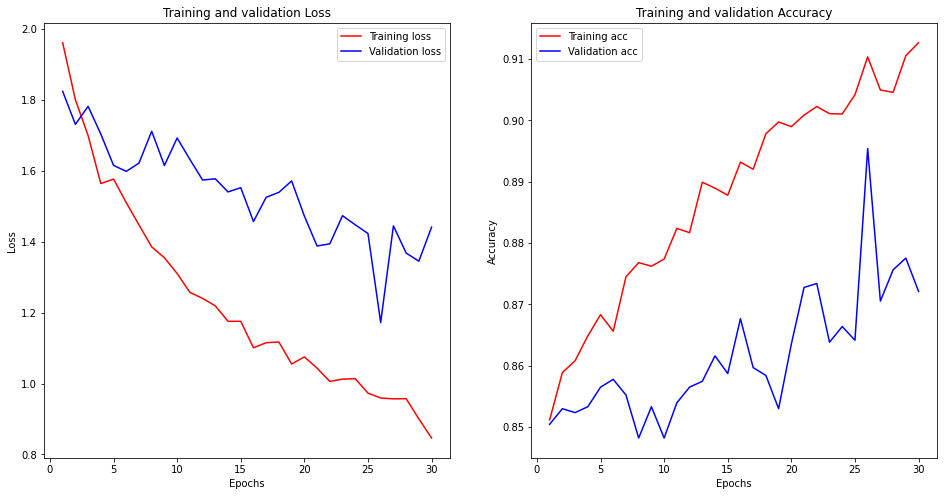

In [ ]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, "r", label="Training loss")
ax.plot(epochs, val_loss_values, "b", label="Validation loss")
ax.set_title("Training and validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, "r", label="Training acc")
ax.plot(epochs, val_acc_values, "b", label="Validation acc")
ax.set_title("Training and validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

In [ ]:
test_samples = test_generator.samples

test_loss, test_acc = model.evaluate( test_generator )

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(test_samples * test_acc), 
                                       round(test_samples * (1-test_acc) )))

8/8 [==============================] - 2s 213ms/step - loss: 1.4063 - accuracy: 0.8620 - precision: 0.5235 - recall: 0.3772 - auc: 0.8453


ValueError: ignored

In [ ]:

# Atributo do generator que fornece o número de amostras detectadas
test_samples = test_generator.samples

test_loss, accuracy,_,_,_ = model.evaluate( test_generator )

print("Test Accuracy:", 100*accuracy, "%")
print("Acertos: {} - Erros: {}".format(round(test_samples * accuracy), 
                                       round(test_samples * (1-accuracy) )))

8/8 [==============================] - 2s 212ms/step - loss: 1.4063 - accuracy: 0.8620 - precision: 0.5235 - recall: 0.3772 - auc: 0.8453
Test Accuracy: 86.19903326034546 %
Acertos: 432 - Erros: 69


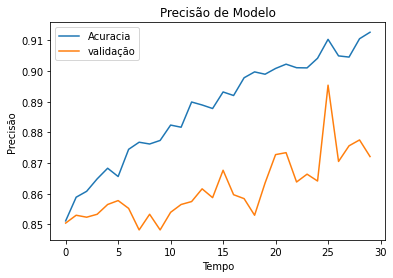

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisão de Modelo')
plt.ylabel('Precisão')
plt.xlabel('Tempo')
plt.legend(['Acuracia', 'validação'], loc = 0)
plt.show()